In [1]:
import numpy as np
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import (
  Conv1DShockClassifierLit, Wav2vec2ShockClassifierLit)


NUM_CLASSES = 4

def get_seisLM_config():

  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/seisLM_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)

  config.model_args.num_classes = NUM_CLASSES
  return config


seisLM_config = get_seisLM_config()

model = Wav2vec2ShockClassifierLit(
  model_config=seisLM_config.model_args,
  training_config=seisLM_config.trainer_args,
  ).model

loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=seisLM_config.model_args.num_classes,
  **seisLM_config.data_args
)

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.2.5
Seed set to 42
Seed set to 42


In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

waveforms, _ = next(iter(loaders['test']))

sample_idx = 0
num_channels_to_display = 10

print('model.config.apply_spec_augment', model.config.apply_spec_augment)
# model.train()
# model.config.apply_spec_augment = False
with torch.no_grad():
  # wav2vec2_outputs = model.wav2vec2(
  #   input_values=waveforms.to(device),
  #   attention_mask=None,
  #   output_attentions=False,
  #   output_hidden_states=True
  # )

  wav2vec2_outputs = model.wav2vec2(
    waveforms.to(device),
    attention_mask=None,
    output_attentions=False,
    output_hidden_states=True,
  )

  wav2vec2_outputs1 = model.wav2vec2(
    waveforms.to(device),
    attention_mask=None,
    output_attentions=False,
    output_hidden_states=True,
  )

  # pred = model(waveforms.to(device))
  # print(pred)


model.config.apply_spec_augment True


In [3]:
(wav2vec2_outputs.hidden_states[0] - wav2vec2_outputs1.hidden_states[0]).abs().max()

tensor(413.0964, device='cuda:0')

In [4]:
model.wav2vec2.config.mask_time_prob

0.65

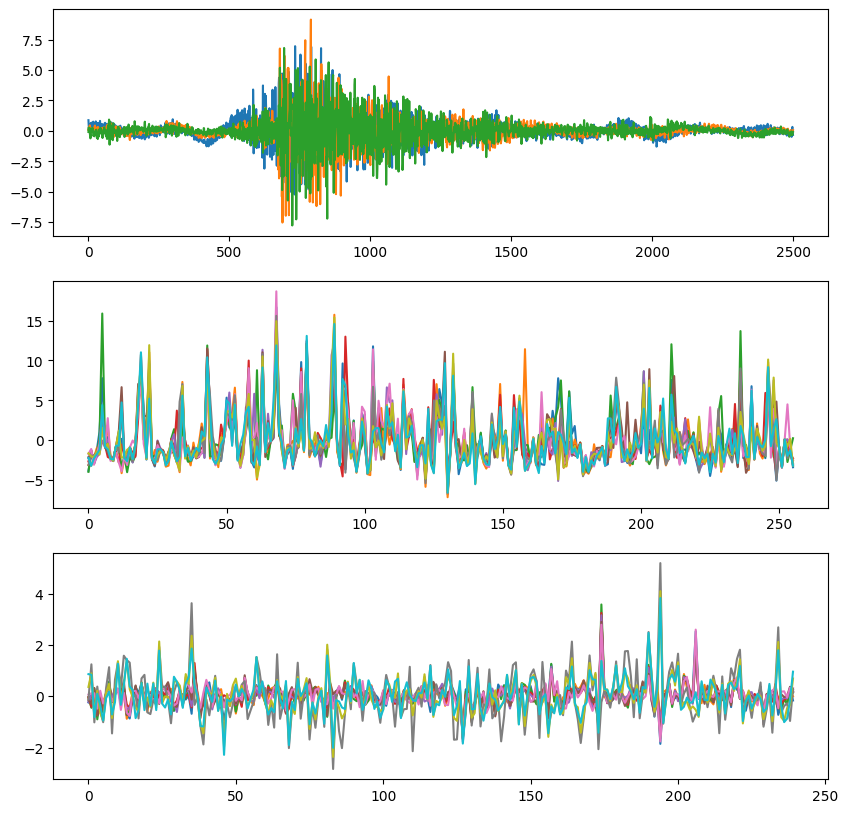

In [5]:
idx = 0
num_channels_to_display = 10
fig, axes = plt.subplots(3, 1, figsize=(10, 10))


axes[0].plot(waveforms[idx].T);
axes[1].plot(wav2vec2_outputs.extract_features[idx][:num_channels_to_display, :].cpu().numpy().T);
axes[2].plot(wav2vec2_outputs.last_hidden_state[idx][:num_channels_to_display, :].cpu().numpy().T);
